# Dice trading

## Part 4 : Simple game

##### 4.a)

$S_t = \{p_t, d_t\}$, avec $p_t$ le nombre de points au tour t et $d_t$ le nombre de dés au tour t

$a_t = \{0, 1\}$, soit acheter un nouveau dé, soit ne rien faire au tour t

$p_t \geq 0$

$0 \leq d_t \leq 3$

$d_{t+1} = d_t + a_{d+1}$

$p_{t+1} = p_t - 5*a_t + \max_{i \in \{1, d_t\}} (u_i)$ ($u_i$ est le score du ième dé)

##### 4.b) Implement an heuristic

3 variables décrivent l'état du système S :
- Le total de point $p_{t}$. Ce total commençant à 0, et le gain maximum étant de 6 par tour, on en déduit l'encadrement suivant : $0 \leq p \leq 60$
- L'action d'acheter un dé $a_{t}$. On a $a_t \in {0,1}$
- Le tour $t$, qui est compris entre 1 et 10

On en déduit que toute stratégie peut être représentée par une matrice 3D de dimension $61*3*10$

REMARQUE IMPORTANTE POUR LA SUITE : La représentation d'une heuristique par une matrice n'est pas unique, car certains états sont inaccessibles (par exemple, avoir plus de 0 points au premier tour). Cela sera pertinent pour la question 4.g).

In [1]:
T=10
never_buy_heuristic = zeros(6*T + 1, 3, T)


buy_heuristic = ones(6*T + 1, 3, T)
for p in 1:6*T + 1
    for t in 1:T
        buy_heuristic[p, 3, t] = 0 # can't buy more than 3 dices
    end
end
for p in 1:6
    for t in 1:T
        for d in 1:3
            buy_heuristic[p, d, t] = 0 # can't buy dices with less than 6 points
        end
    end
end

##### 4.c) Write a simulator giving $V_{\pi}$ in a confidence interval of 95%

In [2]:
using Pkg
Pkg.add("Distributions")
using Distributions
using Random

    Updating registry at `C:\Users\erwan\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `C:\Users\erwan\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\erwan\.julia\environments\v1.8\Manifest.toml`


In [3]:
function simulator_simple_game(politic, T=10, N= 100)
    # This function returns the mean and the 95% confidence interval of the total points after T turns, averaged over N games
    Liste = [] # List of the total points after T turns for each game
    for j in 1:N
        total_points = 0 # The player starts with 0 points
        nb_dice = 1 # The player starts with 1 dice
        for turn in 1:T
            action = politic[total_points + 1, nb_dice, turn] # Due to Julia's indexing system, we need to add 1 to the total_points
            @assert action != 1 || total_points >= 6 "RuleError You don't have enough points to buy a dice. State: $((total_points, nb_dice, turn))"
            @assert action != 1 || nb_dice < 3       "RuleError You can't have more than 3 dices. State: $((total_points, nb_dice, turn))"
            if action == 1  # Note that the rules prevent the player from buying a dice if they have less than 6 points, even though the dice cost is 5 points
                nb_dice += 1
                total_points -= 5
            end
            dice_roll = maximum(rand(1:6, nb_dice))
            total_points += dice_roll
        end
        push!(Liste, total_points) 
    end
    return mean(Liste), [mean(Liste) - (1.96*std(Liste)/sqrt(N)), mean(Liste) + (1.96*std(Liste)/sqrt(N))]
end

T=10
println("""Simulation de la stratégie "jamais acheter" : """,simulator_simple_game(never_buy_heuristic, T, 10000))
println("""Simulation de la stratégie "toujours acheter" : """,simulator_simple_game(buy_heuristic, T, 10000))

Simulation de la stratégie "jamais acheter" : (35.0802, [34.97391032079687, 35.18648967920313])
Simulation de la stratégie "toujours acheter" : (35.9229, [35.82733571244047, 36.018464287559524])


##### 4.d)

On note $X$, $Y$, $Z$ les variables aléatoires associées aux trois dés. Par indépendance, on a :

$\forall k \in 1:6$

$P(Y=k)=1/6$

$P(max(X,Y)\leq k) = P((X\leq k) \cap (Y\leq k)) = P(X\leq k)*P(Y\leq k) = \frac{k^2}{36} \Rightarrow P(max(X,Y)=k) = P(max(X,Y)\leq k) - P(max(X,Y)\leq k-1) = \frac{2k-1}{36}$

$P(max(X,Y,Z)\leq k) = P((X\leq k) \cap (Y\leq k) \cap (Z\leq k)) = P(X\leq k)*P(Y\leq k)*P(Z\leq k) = \frac{k^3}{216} \Rightarrow P(max(X,Y,Z)=k) = P(max(X,Y,Z)\leq k) - P(max(X,Y,Z)\leq k-1) = \frac{3k^2-3k+1}{216}$

In [4]:
function law_max(nb_dices)
    @assert nb_dices > 0 "RuleError You must have at least one dice"
    @assert nb_dices <= 3 "RuleError You can't have more than 3 dices"
    
    if nb_dices == 1
        return DiscreteUniform(1, 6)
    end
    
    if nb_dices == 2
        values = 1:6
        probs = [1/36, 3/36, 5/36, 7/36, 9/36, 11/36]
        return Categorical(probs)
    end

    if nb_dices == 3
        values = 1:6
        probs = [1/216, 7/216, 19/216, 37/216, 61/216, 91/216]
        return Categorical(probs)
    end
end

function general_law_max(nb_dices) #useful for 4.h) and after
    @assert nb_dices > 0 "RuleError You must have at least one dice"
    if nb_dices == 1
        return DiscreteUniform(1, 6)
    end
    values = 1:6
    probs = [(k/6)^nb_dices - ((k-1)/6)^nb_dices for k in values]
    return Categorical(probs)
end

general_law_max (generic function with 1 method)

##### 4.e)

On procède à la programmation dynamique

In [5]:
function dp(T)
    Q = zeros(T*6 + 1, 3, T, 2) # Action-value function Q(s,a), giving the estimates the expected cumulative future rewards starting from state s, taking action a (60 points, 3 dices, 10 turns, 2 actions)
    #Construct the value function for each state at each time
    V = zeros(T*6 + 1, 3, T+1) # Value function V(s), giving the expected cumulative future rewards starting from state s (60 points, 3 dices, 10 turns + 1 for the final state)

    P = zeros(T*6 + 1, 3,  2, T*6 + 1) # Transition probability matrix P(s'|s,a), giving the probability of transitioning to state s' from state s, taking action a (60 points, 3 dices, 10 turns, 2 actions, 60 points)
    # Note that s = (p,d,t), but the probability doesn't depend on t, so we can simplify the matrix to P(p'|p,d,a)
    for p in 0:T*6
        for d in 1:3
            for a in 0:1
                if d + a <= 3
                    law = law_max(d + a) # law_max returns the distribution of the maximum of d + a dices, pdf(law, k) gives the probability of rolling k
                    for p_prime in 0:T*6
                        P[p + 1, d, a + 1, p_prime + 1] = pdf(law, p_prime - p + 5 * a)
                    end
                end
            end
        end
    end
    policy_markov = zeros(T * 6 + 1, 3, T)
    for t in T:-1:1
        for p in 0:T * 6
            for d in 1:3
                V[p + 1, d, t] = -100000 # We initialize the value function to a very low value
                for a in 0:1
                    Q[p + 1, d, t, a + 1] = 0
                    if d + a <= 3 && a * (p-6) >= 0        # We assure that we can't have more than 3 dices AND that we can't buy a dice if we don't have enough points
                        for p_prime in 0:T * 6
                            transition_cost = p_prime - p
                            Q[p + 1, d, t, a + 1] += P[p + 1, d, a + 1, p_prime + 1] * (transition_cost + V[p_prime + 1, d + a, t+1])
                        end
                        if Q[p + 1, d, t, a + 1] > V[p + 1, d, t]
                            V[p + 1, d, t] = Q[p + 1, d, t, a + 1]
                            policy_markov[p + 1, d, t] = a
                        end
                    end
                end
            end
        end
    end
    policy_markov = round.(Int, policy_markov)
    optimal_value = V[1, 1, 1]
    return policy_markov, optimal_value
end
println("L'espérance de la stratégie optimale est : ", dp(10)[2])

L'espérance de la stratégie optimale est : 37.621527777777764


4.f)

In [6]:
T=10
policy_markov = dp(T)[1]
C = simulator_simple_game(policy_markov, T, 1000000)

(37.618668, [37.608791945415454, 37.628544054584545])

##### 4.g)
Comme indiqué en 4.b), la stratégie "ne jamais acheter" peut être représentée par autre chose qu'une matrice nulle (à cause des valeurs inaccesibles). Ces valeurs inaccesibles sont  :

- $\pi [p,1,t]$ avec $p>6(t-1)$ ou $p<t-1$

- $\pi [p,2,t]$ avec $t=1$ ou $p>6(t-1) - 5$ ou $p<t-1-5$

- $\pi [p,3,t]$ avec $t \leq 2$ ou $p>6(t-1) - 10$ ou $p<t-1-10$

Qu'on peut résumer en :

- $\pi [p,d,t]$ avec $d+1>t$ ou $p>6(t-1) - 5*(d-1)$ ou $p<t - 1 - 5(d-1)$

(On peut remarquer que la formule précédente marche aussi pour $d$ différent de 3)

Pour résoudre ce problème, la fonction suivante mettra toutes ces valeurs inaccessible à 0.


In [7]:
function nullify_inaccessible_values(matrice_3d)
    for p in 1:size(matrice_3d, 1)
        for d in 1:size(matrice_3d, 2)
            for t in 1:size(matrice_3d, 3)
                if d+1>t || p-1 > 6*(t-1) - 5*(d-1) || p - 1 < t - 1 - 5*(d - 1) # don't forget that Julia's indexing system starts at 1
                    matrice_3d[p, d, t] = 0
                end
            end
        end
    end
    return matrice_3d
end

nullify_inaccessible_values (generic function with 1 method)

In [8]:
# We will now implement the dynamic programming with descending time horizon to see when it is never intersting to buy a dice
function is_null(matrice_3d)
    for i in 1:size(matrice_3d, 1)
        for j in 1:size(matrice_3d, 2)
            for k in 1:size(matrice_3d, 3)
                if matrice_3d[i, j, k] != 0
                    return false
                end
            end
        end
    end
    return true
end

for T in 10:-1:1
    policy_markov = nullify_inaccessible_values(dp(T)[1])
    if is_null(policy_markov)
        println("The optimal policy is to never buy a dice for T=$T")
        break
    end
end

The optimal policy is to never buy a dice for T=6


In [9]:
function simple_test_strategy(T, π, d=1)
    for t in 1:T
        println("t=$t : ", π[:, d, t])
    end
end
simple_test_strategy(10, nullify_inaccessible_values(dp(10)[1]),1)

t=1 : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
t=2 : [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
t=3 : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
t=4 : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
t=5 : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
t=6 : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

### 4.h)
On reprend les fonctions précédentes en enlevant la condition d<3 :

In [10]:
function no_dice_limit_simulator(politic, T=10, N= 100)
    # This function returns the mean and the 95% confidence interval of the total points after T turns, averaged over N games
    Liste = [] # List of the total points after T turns for each game
    for j in 1:N
        total_points = 0 # The player starts with 0 points
        nb_dice = 1 # The player starts with 1 dice
        for turn in 1:T
            action = politic[total_points + 1, nb_dice, turn] # Due to Julia's indexing system, we need to add 1 to the total_points
            @assert action != 1 || total_points >= 6 "RuleError You don't have enough points to buy a dice. State: $((total_points, nb_dice, turn))"
            if action == 1  # Note that the rules prevent the player from buying a dice if they have less than 6 points, even though the dice cost is 5 points
                nb_dice += 1
                total_points -= 5
            end
            dice_roll = maximum(rand(1:6, nb_dice))
            total_points += dice_roll
        end
        push!(Liste, total_points) 
    end
    return mean(Liste), [mean(Liste) - (1.96*std(Liste)/sqrt(N)), mean(Liste) + (1.96*std(Liste)/sqrt(N))]
end

function no_dice_limit_dp(T)
    Q = zeros(T*6 + 1, T+1, T, 2) # Action-value function Q(s,a), giving the estimates the expected cumulative future rewards starting from state s, taking action a (60 points, 3 dices, 10 turns, 2 actions)
    #Construct the value function for each state at each time
    V = zeros(T*6 + 1, T+1, T+1) # Value function V(s), giving the expected cumulative future rewards starting from state s (60 points, 3 dices, 10 turns + 1 for the final state)

    P = zeros(T*6 + 1, T+1,  2, T*6 + 1) # Transition probability matrix P(s'|s,a), giving the probability of transitioning to state s' from state s, taking action a (60 points, 3 dices, 10 turns, 2 actions, 60 points)
    # Note that s = (p,d,t), but the probability doesn't depend on t nor d', so we can simplify the matrix to P(p'|p,d,a)
    for p in 0:T*6
        for d in 1:T
            for a in 0:1
                law = general_law_max(d + a) # law_max returns the distribution of the maximum of d + a dices, pdf(law, k) gives the probability of rolling k
                for p_prime in 0:T*6
                    P[p + 1, d, a + 1, p_prime + 1] = pdf(law, p_prime - p + 5 * a)
                end
            end
        end
    end
    policy_markov = zeros(T * 6 + 1, T+1, T)
    for t in T:-1:1
        for p in 0:T * 6
            for d in 1:T
                V[p + 1, d, t] = -100000 # We initialize the value function to a very low value
                for a in 0:1
                    Q[p + 1, d, t, a + 1] = 0
                    if  a * (p-6) >= 0        # We assure that we can't buy a dice if we don't have enough points
                        for p_prime in 0:T * 6
                            transition_cost = p_prime - p
                            Q[p + 1, d, t, a + 1] += P[p + 1, d, a + 1, p_prime + 1] * (transition_cost + V[p_prime + 1, d + a, t+1])
                        end
                        if Q[p + 1, d, t, a + 1] > V[p + 1, d, t]
                            V[p + 1, d, t] = Q[p + 1, d, t, a + 1]
                            policy_markov[p + 1, d, t] = a
                        end
                    end
                end
            end
        end
    end
    policy_markov = round.(Int, policy_markov)
    #optimal_value = V[1, 1, 1]      # I didn't implemented it initially, you might want to add it
    return policy_markov #, optimal_value
end

no_dice_limit_dp (generic function with 1 method)

Remarquons que dans le cas $T=10$, pas plus qu'un dé n'était acheté. Considérons le cas $T=50$

In [11]:
simple_test_strategy(50, nullify_inaccessible_values(no_dice_limit_dp(50)), 5)

t=1 : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
t=2 : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

On remarque qu'il reste interessant d'acheter des dés au delà du 5ème dé dans certaines situations.

## Part 5 : Spending dices

### 5.1)

Remarquons que ce nouveau jeu est très différent du précédent : en effet, le joueur doit effectué une action avant et après le lancer. Il n'est donc pas possible de simplement "complexifier" le modèle précédent en ajoutant une action, il faut modifier entièrement les états. Pour celà, on découpe chaque tour en deux parties : avant le lancer et après le lancer. On pourrait doubler le pas de temps t, mais afin de garder la cohérence entre le code et les données de l'énoncé, nous allons introduire la variable binaire r et l'entier vr.

On définit alors un état $s = (p, d, t, r)$ avec :
- $p_{t,r}$ le nombre de points du joueur au début du tour t
- $d_{t,r}$ le nombre de dés au début du tour t
- $vr_{t,r}$ est la valeur du lancer au tour t. Notons que $vr_{t,r}$ n'est pas déterminé pour r=0, on ignorera donc sa valeur.
- $t$ le numéro du tour
- $r$ indicatrice de si les dés du tour t ont déjà été lancés

L'espace des actions change selon la valeur de $r_t$ :
- Si $r$ = 0 (dés non lancés), $a_{t,r}$ = 1 si un dé est acheté, 0 sinon
- Si $r$ = 1 (dés lancés), $a_{t,r}$ =1 si le joueur vend un dé pour doubler son score

Pour une partie à T tours avec une limite de k dés, les contraintes sont les suivantes :

- $\forall (t,r), \quad 0 \leq p_{t,r} \leq 7t \quad$ (le score ne peut être de plus de 7 au global car au mieux on double le score du dé et on paye pour le nouveau dé à chaque tour)
- $\forall (t,r), \quad 0 \leq d_{t,r} \leq k \quad$ (pour cette question, k = 5) 

(Notons qu'on déjà attribué les points une fois les dés lancés, et les rajouter une deuxième fois dans le cas de la vente d'un dé)
- $vr_{t,1} = \max_{i \in \{1, d_{t,0}+a_{t,0}\}} (u_i) \quad$ ($u_i$ est le score du ième dé) 
- $p_{t,1} = p_{t,0} - 5*a_{t+1,0} + vr_{t,1}$
- $p_{t+1,0} = p_{t,1} + a_{t,1}*(vr_{t,1}) $ 
- $d_{t,1} = d_{t,0} + a_{t,0}$
- $d_{t+1, 0} = d_{t,1} - a_{t,1} $

Avec notre modélisation du problème, une stratégie peut être représentée par une matrice 4D de taille $7T$ x $k$ x $6$ x $T$ x $2$ (l'unicité de la matrice pour une stratégie n'est toujours pas garantie)

In [12]:
function game2_simulator(strategy, T=10, k=5, N=10000)
    # This function returns the mean and the 95% confidence interval of the total points after T turns, averaged over N games
    Liste = [] # List of the total points after T turns for each game
    for j in 1:N
        total_points = 0 # The player starts with 0 points
        nb_dice = 1 # The player starts with 1 dice
        for turn in 1:T
            # Part 1, before the dice roll
            r=0
            vr=1 # vr is undefined at this points, so we will use 1 as a placeholder
            action = strategy[total_points + 1, nb_dice, vr, turn, r+1] # First action, taken before the dice roll
            @assert action != 1 || total_points >= 6 "RuleError You don't have enough points to buy a dice. State: $((total_points, nb_dice, vr, turn, r))"
            @assert action != 1 || nb_dice < k       "RuleError You can't have more than k dices. State: $((total_points, nb_dice, vr, turn, r))"
            if action == 1  # Note that the rules prevent the player from buying a dice if they have less than 6 points, even though the dice cost is 5 points
                nb_dice += 1
                total_points -= 5
            end
            vr = maximum(rand(1:6, nb_dice))
            total_points += vr

            # Part 2, after the dice roll
            r=1
            action = strategy[total_points + 1, nb_dice, vr, turn, r+1] # Second action, taken after the dice roll
            @assert action != 1 || nb_dice > 1 "RuleError You can't sell your unique die. State: $((total_points, nb_dice, turn))"
            if action == 1  # Note that the rules prevent the player from buying a dice if they have less than 6 points, even though the dice cost is 5 points
                nb_dice -= 1
                total_points += vr
            end
        end
        push!(Liste, total_points) 
    end
    return mean(Liste), [mean(Liste) - (1.96*std(Liste)/sqrt(N)), mean(Liste) + (1.96*std(Liste)/sqrt(N))]
end

game2_simulator (generic function with 4 methods)

In [13]:
T=50
k=5
never_buy_nor_sell_heuristic = zeros(7*T + 1, k, 6, T,2)

351×5×6×50×2 Array{Float64, 5}:
[:, :, 1, 1, 1] =
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 ⋮                   
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0

[:, :, 2, 1, 1] =
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 ⋮                   
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0

In [14]:
game2_simulator(never_buy_nor_sell_heuristic, T, k, 10000)

(175.089, [174.85337919646824, 175.32462080353176])

On remarque que notre simulateur donne des résultats similaires au précédent pour la stratégie n'achetant rien (ce qui est cohérent).

In [15]:
function game2_dp(T,k=5)
    Q = zeros(T*7 + 1, k, 6, T, 2, 2) # Action-value function Q(s,a), giving the estimates the expected cumulative future rewards starting from state s, taking action a (60 points, 3 dices, 10 turns, 2 actions)
    #Construct the value function for each state at each time
    V = zeros(T*7 + 1, k, 6, T+1, 2) # Value function V(s), giving the expected cumulative future rewards starting from state s (60 points, 3 dices, 10 turns + 1 for the final state)

    P = zeros(T*7 + 1, k,  2, T*7 + 1) # Transition probability matrix P(s'|s,a), giving the probability of transitioning to state s' from state s, taking action a (60 points, 3 dices, 10 turns, 2 actions, 60 points)
    #= Note that s = (p,d,t), but the probability doesn't depend on d', vr, vr', and the transition from (t,1) to (t+1,0) is deterministic,
       so we can simplify the matrix to P(p'|p,d,a) and consider it only to compute transition from (t,0) to (t,1). 
    =#
    for p in 0:T*7
        for d in 1:k
            for a in 0:1
                if d + a <= k
                    law = general_law_max(d + a) # law_max returns the distribution of the maximum of d + a dices, pdf(law, k) gives the probability of rolling k
                    for p_prime in 0:T*7
                        P[p + 1, d, a + 1, p_prime + 1] = pdf(law, p_prime - p + 5 * a)
                    end
                end
            end
        end
    end
    # Note that we have p' = p - 5a + vr
    policy_markov = zeros(T * 7 + 1, k, 6, T, 2)
    for t in T:-1:1
        for r in 1:-1:0
            for p in 0:T*7
                for d in 1:k
                    for vr in 1:6
                        V[p + 1, d, vr, t, r + 1] = -100000 # We initialize the value function to a very low value
                        for a in 0:1
                            Q[p + 1, d, vr, t, r + 1, a + 1] = 0 #Useless ?
                            if r == 0 # We are in the first part of the turn, before the dice roll
                                if  a * (p-6) >= 0 && d+a <= k     # We assure that we can't buy a dice if we don't have enough points AND that we can't have more than k dices
                                    for p_prime in 0:T * 6
                                        transition_cost = p_prime - p
                                        if transition_cost + 5*a >= 1 && transition_cost + 5*a <= 6 # We assure that vr is between 1 and 6
                                            Q[p + 1, d, vr, t, r + 1, a + 1] += P[p + 1, d, a + 1, p_prime + 1] * (transition_cost + V[p_prime + 1, d + a, transition_cost + 5*a, t, r+2]) # We add 2 to r to go to the second part of the turn
                                        end
                                    end
                                    #if p>5
                                    #    println("p=$p, d=$d, vr=$vr, t=$t, r=$r, a=$a", " Q=", Q[p + 1, d, vr, t, r + 1, a + 1], " V=", V[p + 1, d, vr, t, r + 1])
                                    #end
                                    if Q[p + 1, d, vr, t, r + 1, a + 1] > V[p + 1, d, vr, t, r + 1]
                                        V[p + 1, d, vr, t, r + 1] = Q[p + 1, d, vr, t, r + 1, a + 1]
                                        policy_markov[p + 1, d, vr, t, r + 1] = a
                                    end
                                end
                            end
                            if r == 1 # We are in the second part of the turn, after the dice roll
                                #in this case, V is deterministic with vr and a 
                                if a == 0 && V[p + 1, d, vr, t, 2] < V[p + 1, d, vr, t+1, 1] # We don't sell the dice, so V don't change
                                    V[p + 1, d, vr, t, 2] = V[p + 1, d, vr, t+1, 1]
                                    policy_markov[p + 1, d, vr, t, r + 1] = a
                                end
                                if a == 1 && d>1 && V[p + 1, d, vr, t, 2] < vr + V[p + 1, d-1, vr, t+1, 1]  # We sell the dice (if it's possible), so V[p,d,vr,t,r] = vr + the expected value with one less dice
                                    V[p + 1, d, vr, t, 2] = vr + V[p + 1, d-1, vr, t+1, 1]
                                    policy_markov[p + 1, d, vr, t, r + 1] = a
                                end
                            end
                        end
                    end
                end
            end
        end
    end
    policy_markov = round.(Int, policy_markov)
    return policy_markov
end

game2_dp (generic function with 2 methods)

In [16]:
function simple_test_strategy(T, π, d=1, vr=1, r=0)
    for t in 1:T
        println("t=$t : ", π[:, d, vr, t, r+1])
    end
end
k=5
T=10
simple_test_strategy(T, game2_dp(T, k), 2, 6, 0)

t=1 : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
t=2 : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
t=3 : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
t=4 : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
t=5 : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [17]:
T=50
k=5
game2_simulator(game2_dp(T, k), T, k, 10000)

(288.1822, [287.98544208237087, 288.3789579176292])

5.2)

In [18]:
T=50
k=T
game2_simulator(game2_dp(T, k), T, k, 10000)

(305.0933, [304.9712420748695, 305.2153579251305])

Comme attendu, l'esperance de gain de la stratégie optimal augmente. On peut chercher à regarder son évolution en fonction du nombre de dé autorisé.

In [19]:
kmax = 10
T=10
score = zeros(kmax)
for i in 1:kmax
    score[i] = game2_simulator(game2_dp(T, i), T, i, 10000)[1]
end
score

10-element Vector{Float64}:
 34.999
 44.118
 46.8253
 47.5122
 47.661
 47.4974
 47.4766
 47.4811
 47.4871
 47.6018

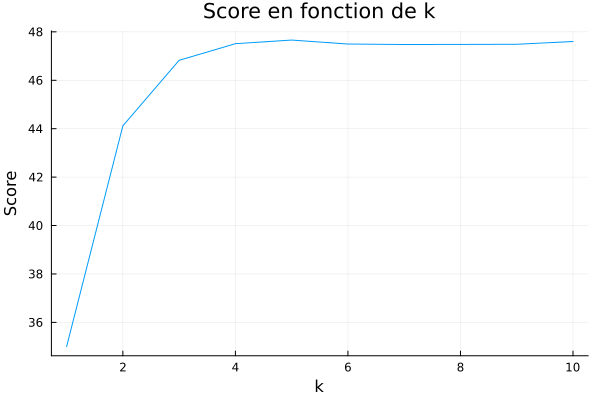

In [20]:
using Plots
plot(1:kmax, score, title = "Score en fonction de k", xlabel = "k", ylabel = "Score", legend = false)
#savefig("score_k_T10.png")

Pour T=10, on remarque que la stratégie semble se stabiliser vers k=4 (ce qui signifique que la stratégie optimal sans limite dépasse très rarement 4 dés dans le cas à 50 tours)

Pour T=50, on remarque que la stratégie semble se stabiliser vers k=12 (ce qui signifique que la stratégie optimal sans limite dépasse très rarement 12 dés dans le cas à 50 tours)

5.c) On ajoute cette fois ci un coût finale dépendant du nombre de dés. L'implémentation se fait assez simplement à partir de la précédente fonction de calcul de politique optimale.

In [21]:
function fcost_game2_dp(T, k, Ktable)
    @assert size(Ktable)[1] == T*7+1 && size(Ktable)[2] == k "ValueError: Ktable must have size (T*7+1, k), had size $(size(Ktable))"
    Q = zeros(T*7 + 1, k, 6, T, 2, 2) # Action-value function Q(s,a), giving the estimates the expected cumulative future rewards starting from state s, taking action a (60 points, 3 dices, 10 turns, 2 actions)
    #Construct the value function for each state at each time
    V = zeros(T*7 + 1, k, 6, T+1, 2) # Value function V(s), giving the expected cumulative future rewards starting from state s (60 points, 3 dices, 10 turns + 1 for the final state)

    # We initialize the value function for the final state
    for d in 1:k
        for p in 0:T*7
            for j in 1:6
                V[p+1, d, j, T+1, 1] = Ktable[p+1, d]
            end
        end
    end

    P = zeros(T*7 + 1, k,  2, T*7 + 1) # Transition probability matrix P(s'|s,a), giving the probability of transitioning to state s' from state s, taking action a (60 points, 3 dices, 10 turns, 2 actions, 60 points)
    #= Note that s = (p,d,t), but the probability doesn't depend on d', vr, vr', and the transition from (t,1) to (t+1,0) is deterministic,
       so we can simplify the matrix to P(p'|p,d,a) and consider it only to compute transition from (t,0) to (t,1). 
    =#
    for p in 0:T*7
        for d in 1:k
            for a in 0:1
                if d + a <= k
                    law = general_law_max(d + a) # law_max returns the distribution of the maximum of d + a dices, pdf(law, k) gives the probability of rolling k
                    for p_prime in 0:T*7
                        P[p + 1, d, a + 1, p_prime + 1] = pdf(law, p_prime - p + 5 * a)
                    end
                end
            end
        end
    end
    # Note that we have p' = p - 5a + vr
    policy_markov = zeros(T * 7 + 1, k, 6, T, 2)
    for t in T:-1:1
        for r in 1:-1:0
            for p in 0:T*7
                for d in 1:k
                    for vr in 1:6
                        V[p + 1, d, vr, t, r + 1] = -100000 # We initialize the value function to a very low value
                        for a in 0:1
                            Q[p + 1, d, vr, t, r + 1, a + 1] = 0 #Useless ?
                            if r == 0 # We are in the first part of the turn, before the dice roll
                                if  a * (p-6) >= 0 && d+a <= k     # We assure that we can't buy a dice if we don't have enough points AND that we can't have more than k dices
                                    for p_prime in 0:T * 6
                                        transition_cost = p_prime - p
                                        if transition_cost + 5*a >= 1 && transition_cost + 5*a <= 6 # We assure that vr is between 1 and 6
                                            Q[p + 1, d, vr, t, r + 1, a + 1] += P[p + 1, d, a + 1, p_prime + 1] * (transition_cost + V[p_prime + 1, d + a, transition_cost + 5*a, t, r+2]) # We add 2 to r to go to the second part of the turn
                                        end
                                    end
                                    #if p>5
                                    #    println("p=$p, d=$d, vr=$vr, t=$t, r=$r, a=$a", " Q=", Q[p + 1, d, vr, t, r + 1, a + 1], " V=", V[p + 1, d, vr, t, r + 1])
                                    #end
                                    if Q[p + 1, d, vr, t, r + 1, a + 1] > V[p + 1, d, vr, t, r + 1]
                                        V[p + 1, d, vr, t, r + 1] = Q[p + 1, d, vr, t, r + 1, a + 1]
                                        policy_markov[p + 1, d, vr, t, r + 1] = a
                                    end
                                end
                            end
                            if r == 1 # We are in the second part of the turn, after the dice roll
                                #in this case, V is deterministic with vr and a 
                                if a == 0 && V[p + 1, d, vr, t, 2] < V[p + 1, d, vr, t+1, 1] # We don't sell the dice, so V don't change
                                    V[p + 1, d, vr, t, 2] = V[p + 1, d, vr, t+1, 1]
                                    policy_markov[p + 1, d, vr, t, r + 1] = a
                                end
                                if a == 1 && d>1 && V[p + 1, d, vr, t, 2] < vr + V[p + 1, d-1, vr, t+1, 1]  # We sell the dice (if it's possible), so V[p,d,vr,t,r] = vr + the expected value with one less dice
                                    V[p + 1, d, vr, t, 2] = vr + V[p + 1, d-1, vr, t+1, 1]
                                    policy_markov[p + 1, d, vr, t, r + 1] = a
                                end
                            end
                        end
                    end
                end
            end
        end
    end
    optimal_values = V[:, :, 1, 1, 1]
    policy_markov = round.(Int, policy_markov)
    return policy_markov, optimal_values
end

fcost_game2_dp (generic function with 1 method)

In [22]:
T = 10
k = 5
Knull = zeros(T*7 + 1, k) #used for test
Klist = [0,2,3,5,8]
Ktable = [Klist[d] for p in 0:T*7, d in 1:k]

policy_markov, optimal_values_null = fcost_game2_dp(T, k, Knull)
π, optimal_values = fcost_game2_dp(T, k, Ktable)
optimal_values_null[1,1], optimal_values[1, 1]

(47.58408458727193, 47.70163699374413)

5.d) La valeur du coup final ne doit plus dépendre que de d mais aussi de p (score). Cette valeur est $k_{p,d}=V(p,d,10)$, avec $V(p,d,1)$ l'espérance des gains lorsqu'on commence avec p points et d dés.

Pour vérifier cela, nous devons une dernière fois modifier la fonction de programmation dynamique, afin d'augmenter l'ensemble des prix possibles

In [23]:
function final_game2_dp(T, k, Ktable)
    @assert size(Ktable)[1] == T*14+1 && size(Ktable)[2] == k "ValueError: Ktable must have size (T*14+1, k), had size $(size(Ktable))"
    Q = zeros(T*14 + 1, k, 6, T, 2, 2) # Action-value function Q(s,a), giving the estimates the expected cumulative future rewards starting from state s, taking action a (60 points, 3 dices, 10 turns, 2 actions)
    #Construct the value function for each state at each time
    V = zeros(T*14 + 1, k, 6, T+1, 2) # Value function V(s), giving the expected cumulative future rewards starting from state s (60 points, 3 dices, 10 turns + 1 for the final state)
    # We initialize the value function for the final state
    for d in 1:k
        for p in 0:T*14
            for j in 1:6
                V[p+1, d, j, T+1, 1] = Ktable[p+1, d]
            end
        end
    end

    P = zeros(T*14 + 1, k,  2, T*14 + 1) # Transition probability matrix P(s'|s,a), giving the probability of transitioning to state s' from state s, taking action a (60 points, 3 dices, 10 turns, 2 actions, 60 points)
    #= Note that s = (p,d,t), but the probability doesn't depend on d', vr, vr', and the transition from (t,1) to (t+1,0) is deterministic,
       so we can simplify the matrix to P(p'|p,d,a) and consider it only to compute transition from (t,0) to (t,1). 
    =#
    for p in 0:T*14
        for d in 1:k
            for a in 0:1
                if d + a <= k
                    law = general_law_max(d + a) # law_max returns the distribution of the maximum of d + a dices, pdf(law, k) gives the probability of rolling k
                    for p_prime in 0:T*14
                        P[p + 1, d, a + 1, p_prime + 1] = pdf(law, p_prime - p + 5 * a)
                    end
                end
            end
        end
    end
    # Note that we have p' = p - 5a + vr
    policy_markov = zeros(T*7*2 + 1, k, 6, T, 2)
    for t in T:-1:1
        for r in 1:-1:0
            for p in 0:T*14
                for d in 1:k
                    for vr in 1:6
                        V[p + 1, d, vr, t, r + 1] = -100000 # We initialize the value function to a very low value
                        for a in 0:1
                            Q[p + 1, d, vr, t, r + 1, a + 1] = 0 #Useless ?
                            if r == 0 # We are in the first part of the turn, before the dice roll
                                if  a * (p-6) >= 0 && d+a <= k     # We assure that we can't buy a dice if we don't have enough points AND that we can't have more than k dices
                                    for p_prime in 0:T * 6
                                        transition_cost = p_prime - p
                                        if transition_cost + 5*a >= 1 && transition_cost + 5*a <= 6 # We assure that vr is between 1 and 6
                                            Q[p + 1, d, vr, t, r + 1, a + 1] += P[p + 1, d, a + 1, p_prime + 1] * (transition_cost + V[p_prime + 1, d + a, transition_cost + 5*a, t, r+2]) # We add 2 to r to go to the second part of the turn
                                        end
                                    end
                                    #if p>5
                                    #    println("p=$p, d=$d, vr=$vr, t=$t, r=$r, a=$a", " Q=", Q[p + 1, d, vr, t, r + 1, a + 1], " V=", V[p + 1, d, vr, t, r + 1])
                                    #end
                                    if Q[p + 1, d, vr, t, r + 1, a + 1] > V[p + 1, d, vr, t, r + 1]
                                        V[p + 1, d, vr, t, r + 1] = Q[p + 1, d, vr, t, r + 1, a + 1]
                                        policy_markov[p + 1, d, vr, t, r + 1] = a
                                    end
                                end
                            end
                            if r == 1 # We are in the second part of the turn, after the dice roll
                                #in this case, V is deterministic with vr and a 
                                if a == 0 && V[p + 1, d, vr, t, 2] < V[p + 1, d, vr, t+1, 1] # We don't sell the dice, so V don't change
                                    V[p + 1, d, vr, t, 2] = V[p + 1, d, vr, t+1, 1]
                                    policy_markov[p + 1, d, vr, t, r + 1] = a
                                end
                                if a == 1 && d>1 && V[p + 1, d, vr, t, 2] < vr + V[p + 1, d-1, vr, t+1, 1]  # We sell the dice (if it's possible), so V[p,d,vr,t,r] = vr + the expected value with one less dice
                                    V[p + 1, d, vr, t, 2] = vr + V[p + 1, d-1, vr, t+1, 1]
                                    policy_markov[p + 1, d, vr, t, r + 1] = a
                                end
                            end
                        end
                    end
                end
            end
        end
    end
    optimal_values = V[:, :, 1, 1, 1]
    policy_markov = round.(Int, policy_markov)
    return policy_markov, optimal_values
end

final_game2_dp (generic function with 1 method)

In [24]:
T = 20
k = 5
Knull = zeros(T*7 + 1, k) #used for test
π, optimal_values = fcost_game2_dp(T, k, Knull)
optimal_values[1,1]

107.53503911416364

In [25]:
T = 10
k = 5
Knull = zeros(2*T*7 + 1, k) #used for test
π, optimal_values = final_game2_dp(T, k, Knull)
π, optimal_values = final_game2_dp(T, k, optimal_values)
optimal_values[1,1]

107.53503743302468

On a bien la valeur attendue (aux erreurs d'arrondis près).